# Table Extraction
**Documents Tables Detection** on UNLV dataset using Deep Learning.

Following are the libraries that we will import.

In [1]:
# Import Libraries
from __future__ import print_function

!pip install tensorflow-gpu==2.8.0rc0
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras import losses
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from keras.utils.generic_utils import Progbar
#from keras.backend.common import image_dim_ordering
from keras import backend as K

# Get image data format ('channels_first' or 'channels_last')
image_data_format = K.image_data_format()

import copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.8/952.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 27.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard

## Download Data
First, we need the data. For this project, we will download and extract the **UNLV dataset**. The dataset can be downloaded from the link [here](https://drive.google.com/file/d/1r3KbLvCufqsnP5QxpPhrVeUG7BF9p0Jr/view?usp=drive_link).

In [2]:
# Download data from local repository
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
%cd /content
!mkdir data_fasterrcnn
!cp -r "/content/gdrive/MyDrive/document-table-detection-master/data.zip" "/content/data_fasterrcnn/"

/content


In [4]:
# Unzip data
!unzip /content/data_fasterrcnn/data -d /content/data_fasterrcnn/

Archive:  /content/data_fasterrcnn/data.zip
   creating: /content/data_fasterrcnn/images/
  inflating: /content/data_fasterrcnn/images/0101_003.png  
  inflating: /content/data_fasterrcnn/images/0110_099.png  
  inflating: /content/data_fasterrcnn/images/0113_013.png  
  inflating: /content/data_fasterrcnn/images/0140_007.png  
  inflating: /content/data_fasterrcnn/images/0146_281.png  
  inflating: /content/data_fasterrcnn/images/0147_090.png  
  inflating: /content/data_fasterrcnn/images/0147_125.png  
  inflating: /content/data_fasterrcnn/images/0147_256.png  
  inflating: /content/data_fasterrcnn/images/0148_271.png  
  inflating: /content/data_fasterrcnn/images/0148_479.png  
  inflating: /content/data_fasterrcnn/images/0151_180.png  
  inflating: /content/data_fasterrcnn/images/0151_208.png  
  inflating: /content/data_fasterrcnn/images/0154_080.png  
  inflating: /content/data_fasterrcnn/images/0154_474.png  
  inflating: /content/data_fasterrcnn/images/0155_081.png  
  inflatin

## Data Preprocessing

### Load Ground Truth CSV Files

Once the dataset is downloaded, it reveals the presence of an "images" folder and two CSV files—specifically, train.csv and test.csv. The subsequent step involves loading both CSV files into Pandas DataFrames to facilitate convenient indexing.

The provided code is responsible for executing the loading process of the CSV files into the Pandas DataFrames.

In [5]:
# Load CSV Files into DataFrames
train_file = pd.read_csv('/content/data_fasterrcnn/train.csv',names=['image_names','xmin','ymin','xmax','ymax','class'])
test_file = pd.read_csv('/content/data_fasterrcnn/val.csv',names=['image_names','xmin','ymin','xmax','ymax','class'])

# Display DataFrames
print("\nTraining Ground Truth")
display(train_file.head())
print("\nTesting Ground Truth")
display(test_file.head())


Training Ground Truth


,image_names,xmin,ymin,xmax,ymax,class
0,0101_003.png,770,946,2070,2973,table
1,0110_099.png,270,1653,2280,2580,table
2,0113_013.png,303,343,2273,2953,table
3,0140_007.png,664,1782,1814,2076,table
4,0146_281.png,704,432,1744,1552,table



Testing Ground Truth


,image_names,xmin,ymin,xmax,ymax,class
0,9533_039.png,60,396,1113,2420,table
1,9533_039.png,1143,1126,2240,2230,table
2,9534_001.png,196,378,2146,956,table
3,9534_001.png,184,1028,2160,1636,table
4,9534_028.png,642,1388,1944,1981,table


### Resize Images and Bbox Coordinates
Due to the large size of the original images, where the smallest width and height are 2544 pixels, there is a potential for memory overflow during training. Moreover, the images exhibit varying sizes. To mitigate these issues, we intend to resize all images to a uniform dimension of 256 x 256 pixels and adjust the bounding box coordinates accordingly.

The provided code is responsible for executing the resizing process for both the images and the associated bounding box coordinates.

In [6]:
def data_loading_and_resizing(image_file):
  image_list = image_file['image_names'].unique()
  images = []
  labels = []
  for image_name in image_list:
    image = cv2.imread('/content/data_fasterrcnn/images/'+image_name)

    x_scale = 256 / image.shape[1]
    y_scale = 256 / image.shape[0]

    # Resize Images to 256px x 256px
    image = cv2.resize(image, (256,256))

    # Resize the bbox coordinates
    image_file.loc[image_file['image_names'] == image_name,'xmin'] = np.round(image_file.loc[image_file['image_names'] == image_name,'xmin'] * x_scale)
    image_file.loc[image_file['image_names'] == image_name,'ymin'] = np.round(image_file.loc[image_file['image_names'] == image_name,'ymin'] * y_scale)
    image_file.loc[image_file['image_names'] == image_name,'xmax'] = np.round(image_file.loc[image_file['image_names'] == image_name,'xmax'] * x_scale)
    image_file.loc[image_file['image_names'] == image_name,'ymax'] = np.round(image_file.loc[image_file['image_names'] == image_name,'ymax'] * y_scale)

    bboxes = image_file.loc[image_file['image_names'] == image_name,'xmin':'ymax'].values.astype(np.int32)
    labels.append(bboxes)

    images.append(image)

  return images, labels, image_file

In [7]:
# Resize and Load Data
train_images, train_labels, train_file = data_loading_and_resizing(train_file)
test_images, test_labels, test_file = data_loading_and_resizing(test_file)

# Display DataFrames
print("\nResized Training Ground Truth")
display(train_file.head())
print("\nResized Testing Ground Truth")
display(test_file.head())


Resized Training Ground Truth


,image_names,xmin,ymin,xmax,ymax,class
0,0101_003.png,77,73,208,231,table
1,0110_099.png,27,128,229,200,table
2,0113_013.png,30,27,229,229,table
3,0140_007.png,66,138,181,161,table
4,0146_281.png,71,34,175,120,table



Resized Testing Ground Truth


,image_names,xmin,ymin,xmax,ymax,class
0,9533_039.png,6,31,112,188,table
1,9533_039.png,115,87,225,173,table
2,9534_001.png,20,29,215,74,table
3,9534_001.png,18,80,217,127,table
4,9534_028.png,64,108,195,154,table


### Data Visualization
Before creating the ground truth anchors, it is essential to visualize both the training and testing datasets.

In [8]:
def visualize(index_list, images, labels):
  rows = 2
  columns = 3
  fig=plt.figure(figsize=(16, 12))
  for i, index in enumerate(index_list):
    fig.add_subplot(rows, columns, i+1, xticks=[], yticks=[])
    image = images[index]
    for label in labels[index]:
      cv2.rectangle(image,(label[0], label[1]),(label[2],label[3]),(255, 0, 0))
    plt.imshow(image)
  plt.show()

Train Image Dataset


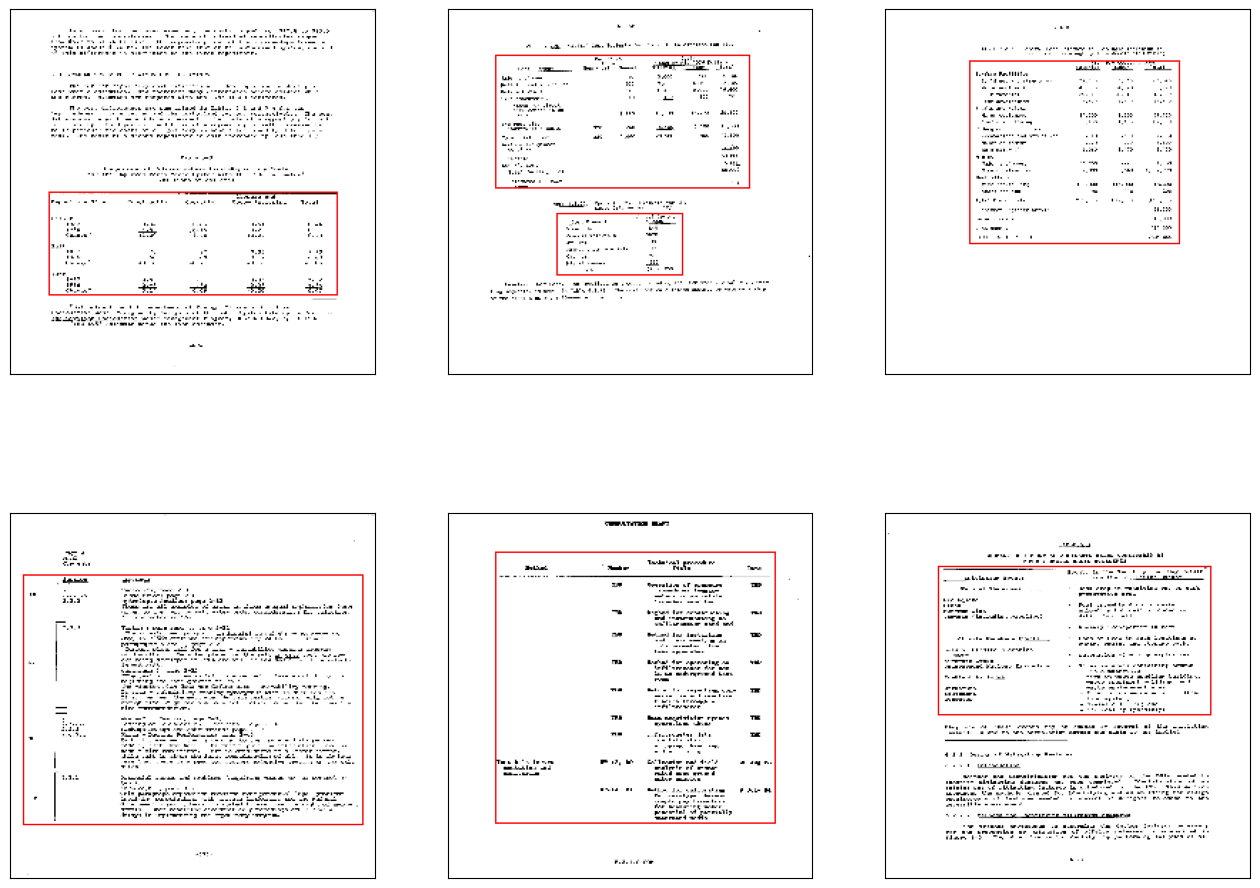

In [9]:
print('Train Image Dataset')
visualize([1,5,10,15,20,25], np.copy(train_images), train_labels)

Test Image Dataset


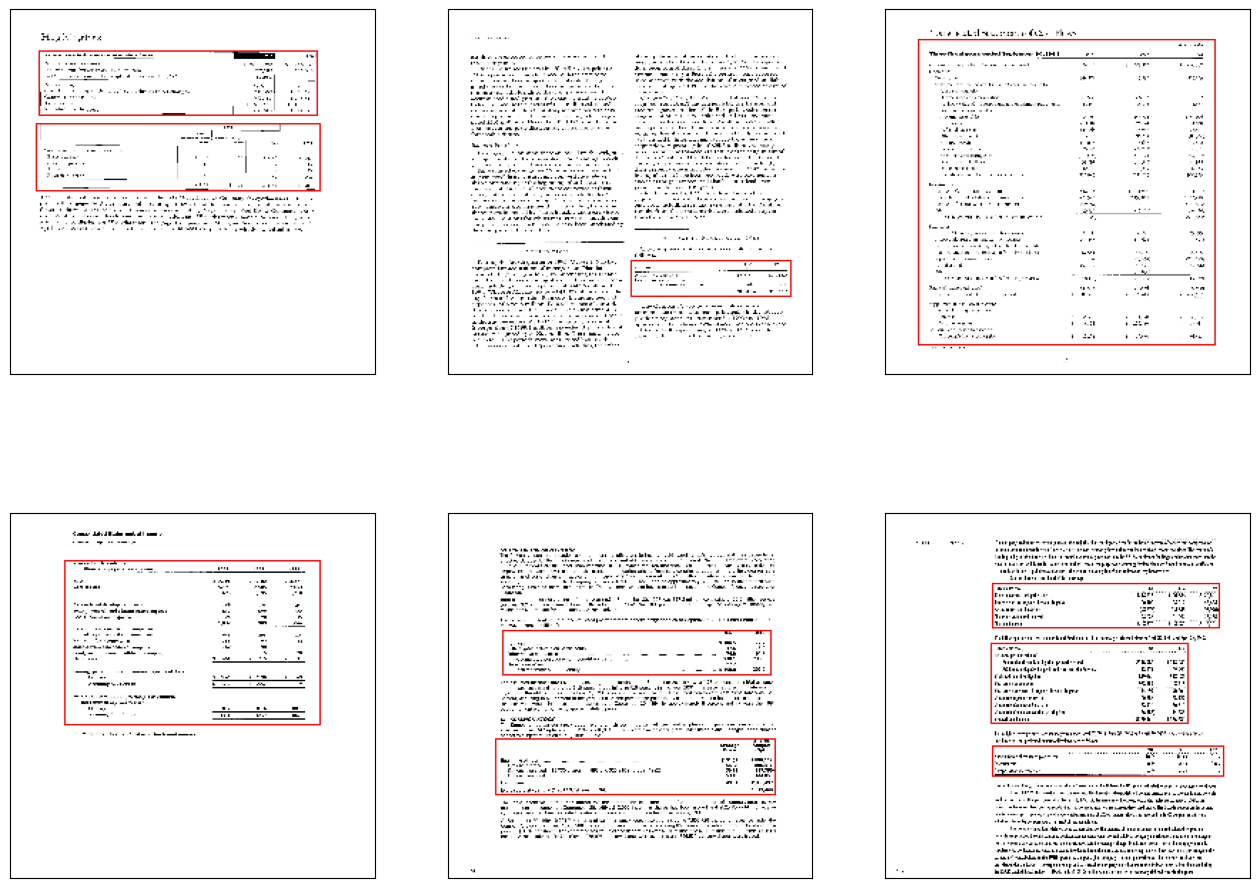

In [10]:
print('Test Image Dataset')
visualize([1,5,10,15,20,25], np.copy(test_images), test_labels)

### Generate Ground Truth Anchors

After observing the visualizations above, it's apparent that the number of tables in a document image is variable. This variability presents a challenge when passing bbox coordinates as ground truth in a TensorFlow model. To address this issue of variable length, a solution is implemented by generating a fixed number of anchors. These anchors serve as reference bounding boxes for the images.

The following code is dedicated to generating a specific number of ground truth anchors for the images.


This code defines three functions (union, intersection, and iou) related to calculating the Intersection over Union (IoU) between two bounding boxes. IoU is commonly used in object detection tasks to evaluate the overlap between predicted and ground truth bounding boxes.

In [11]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [12]:
def calc_rpn(image_data, labels, width, height, resized_width, resized_height):

  downscale = float(16)
  anchor_sizes = [64, 128, 256]
  anchor_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
  num_anchors = 9

  output_width = resized_width // 16
  output_height = resized_height // 16

  n_anchratios = len(anchor_ratios)

  num_bboxes = len(labels)

  y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
  y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
  y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

  num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
  best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
  best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
  best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
  best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

  gta = np.zeros((num_bboxes, 4))
  for bbox_num, label in enumerate(labels):
		# get the GT box coordinates, and resize to account for image resizing
    gta[bbox_num, 0] = label[0]
    gta[bbox_num, 1] = label[1]
    gta[bbox_num, 2] = label[2]
    gta[bbox_num, 3] = label[3]

  for anchor_size_idx in range(len(anchor_sizes)):
    for anchor_ratio_idx in range(n_anchratios):
      anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
      anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]

      for ix in range(output_width):
				# x-coordinates of the current anchor box
        x1_anc = downscale * (ix + 0.5) - anchor_x / 2
        x2_anc = downscale * (ix + 0.5) + anchor_x / 2

				# ignore boxes that go across image boundaries
        if x1_anc < 0 or x2_anc > resized_width:
          continue

        for jy in range(output_height):

					# y-coordinates of the current anchor box
          y1_anc = downscale * (jy + 0.5) - anchor_y / 2
          y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
          if y1_anc < 0 or y2_anc > resized_height:
            continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
          bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
          best_iou_for_loc = 0.0

          for bbox_num in range(num_bboxes):

						# get IOU of the current GT box and the current anchor box
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
            if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > 0.7:
              cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
              cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
              cxa = (x1_anc + x2_anc)/2.0
              cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
              tx = (cx - cxa) / (x2_anc - x1_anc)
              ty = (cy - cya) / (y2_anc - y1_anc)
              tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
              th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

            #if image_data['bboxes'][bbox_num]['class'] != 'bg':

            # all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
            if curr_iou > best_iou_for_bbox[bbox_num]:
              best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
              best_iou_for_bbox[bbox_num] = curr_iou
              best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
              best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

            # we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
            if curr_iou > 0.7:
              bbox_type = 'pos'
              num_anchors_for_bbox[bbox_num] += 1
              # we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
              if curr_iou > best_iou_for_loc:
                best_iou_for_loc = curr_iou
                best_regr = (tx, ty, tw, th)

            # if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
            if 0.3 < curr_iou < 0.7:
              # gray zone between neg and pos
              if bbox_type != 'pos':
                bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
          if bbox_type == 'neg':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
          elif bbox_type == 'neutral':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
          elif bbox_type == 'pos':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
            y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region
  for idx in range(num_anchors_for_bbox.shape[0]):
    if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
      if best_anchor_for_bbox[idx, 0] == -1:
        continue
      y_is_box_valid[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3]] = 1
      y_rpn_overlap[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3]] = 1
      start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
      y_rpn_regr[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

  y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
  y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

  y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
  y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

  y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
  y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

  pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
  neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

  num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
  num_regions = 256

  if len(pos_locs[0]) > num_regions/2:
    val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
    y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
    num_pos = num_regions/2

  if len(neg_locs[0]) + num_pos > num_regions:
    val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
    y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

  y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
  y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

  return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

In [13]:
def get_anchor_gt(images, labels):
  resized_width = 256
  resized_height = 256
  while True:
    for index in range(len(images)):
      image_data = images[index]
      label_data = labels[index]
      try:

        try:
          y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(image_data, label_data, 256, 256, resized_width, resized_height)
        except:
          continue

        # Zero-center by mean pixel, and preprocess image

        image_data = image_data[:,:, (2, 1, 0)]  # BGR -> RGB
        image_data = image_data.astype(np.float32)
        image_data[:, :, 0] -= 103.939
        image_data[:, :, 1] -= 116.779
        image_data[:, :, 2] -= 123.68
        image_data /= 1.0

        image_data = np.transpose(image_data, (2, 0, 1))
        image_data = np.expand_dims(image_data, axis=0)

        y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= 1.0

        image_data = np.transpose(image_data, (0, 2, 3, 1))
        y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
        y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

        yield np.copy(image_data), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], label_data, index

      except Exception as e:
        print(e)
        continue

## Model Layers

The implemented model in this research is composed of the following layers:

1. **Feature Extraction Layer:** This layer is responsible for capturing crucial details and features from the input images.

2. **Region Proposal Network (RPN) Layer:** It functions to propose potential regions within the given images.

3. **RPN to Region of Interest (RoI) Layer:** This layer transforms the proposals from the RPN into distinct regions of interest.

4. **Region of Interest Layer:** Operating with a specific threshold, this layer filters and selects regions from the proposed ones.


### Feature Extraction Layer

In the initial step of our model, we employ a Convolutional Neural Network (CNN) for feature extraction from the images. Specifically, we opt for the **VGG16** model, which is pretrained on **ImageNet**. The features are extracted from the second-to-last layer before max pooling. The resulting feature representation is then passed on to the Region Proposal Network (RPN) Layer.


In [14]:
IMG_SHAPE = (256, 256, 3)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
bottleneck_input  = base_model.get_layer(index=0).input
bottleneck_output = base_model.get_layer(index=-2).output
base_model  = tf.keras.models.Model(inputs=bottleneck_input, outputs=bottleneck_output)

58900480/58889256 [==============================] - 0s 0us/step


In [15]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### Region Proposal Network Layer

Utilizing the features extracted by the pretrained VGG16 model, the Region Proposal Network (RPN) is employed to identify a predetermined number of regions (bounding boxes) containing objects. The RPN takes the count of anchors as input and produces a set of promising proposals. It comprises a convolutional layer, a classification layer, and a regression layer.

For each anchor, the RPN generates an objectness score obtained from the classification layer and a set of bounding box coordinates obtained from the regression layer.


In [16]:
def RPN_Layer(base_layer, num_anchors):
  '''
    base_layer: vgg16
    num_anchors: 9
  '''
  x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layer)

  x_class = tf.keras.layers.Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
  x_regr = tf.keras.layers.Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

  return [x_class, x_regr, base_layer]

### RPN to Region Of Interest Layer

Following the Region Proposal Network (RPN), the RPN to Region Of Interest (RoI) layer comes into play. This layer transforms anchors into regions of interest. It employs the non-maximum suppression technique to eliminate duplicate proposals, where proposals overlapping by Intersection over Union (IoU) greater than 0.7 are removed. Additionally, it selects bounding boxes up to a maximum number, which is set to 300 in our case.


In [17]:
def apply_regr_np(X, T):
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X

In [18]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]


    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

In [19]:
# RPN to ROI
def rpn_to_roi(rpn_layer, regr_layer, dim_ordering, use_regr=True, max_boxes=10,overlap_thresh=0.9):

	regr_layer = regr_layer / 4.0

	anchor_sizes = [64, 128, 256]   # (3 in here)
	anchor_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]  # (3 in here)


	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors)
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/ 16
			anchor_y = (anchor_size * anchor_ratio[1])/ 16

			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4]
			regr = np.transpose(regr, (2, 0, 1))


			# For every point in x, there are all the y points and vice versa
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))
	all_probs = np.transpose(rpn_layer,(0, 3, 1, 2)).reshape((-1))

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

### Filter Regions Of Interest Layer

In the final layer of our model, we filter regions or bounding boxes selected in the previous layer. Specifically, we retain regions with an overlap greater than 0.65 with the ground truth boxes. However, for calculating the accuracy metric (Intersection over Union), we consider only those regions that have an overlap greater than 0.3 with the ground truth boxes.


In [20]:
def filter_roi(labels, Y_pred, thresh= 0.3):
  filter_labels = []
  iou_acc = []
  for label in labels:
    for predicted in Y_pred:
      label_iou = iou(label, predicted)
      if label_iou > thresh:
        iou_acc.append(label_iou)
        filter_labels.append(predicted)

  if iou_acc == []:
    mean = 0
  else:
    mean = np.mean(np.asarray(iou_acc))

  return filter_labels, mean

## Define Classification and Regression Loss


In [21]:
epsilon = 1e-4

In [22]:
# RPN Loss Regression
def rpn_loss_regr(num_anchors):

    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return 1.0 * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num

In [23]:
# RPN Loss Classification
def rpn_loss_cls(num_anchors):

    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return 1.0 * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


## Model Initialization

In [24]:
input_image = tf.keras.layers.Input(shape=(None,None,3))
# VGG16 gives feature map
vgg16 = base_model(input_image)
# RPN Layer x_regr gives mean distance between anchors
rpn = RPN_Layer(vgg16,9)


model_rpn = tf.keras.models.Model(input_image, rpn[:2])
model_rpn.compile(optimizer='adam', loss=[rpn_loss_cls(9), rpn_loss_regr(9)], metrics = ["acc"])
model_rpn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model (Functional)             (None, 16, 16, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 rpn_conv1 (Conv2D)             (None, 16, 16, 512)  2359808     ['model[0][0]']                  
                                                                                                  
 rpn_out_class (Conv2D)         (None, 16, 16, 9)    4617        ['rpn_conv1[0][0]']        

## Training

In [25]:
num_epochs = 50
epoch_num=
losses = np.zeros((338, 3))
loss_cls = []
loss_regr = []
accuracy = []

In [ ]:
for epoch_num in range(num_epochs):
  progbar = Progbar(338)
  print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))

  data_gen_train = get_anchor_gt(train_images, train_labels)
  iter_num = 0
  while True:
    try:

      # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
      X, Y, labels, index = next(data_gen_train)

      # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
      loss_rpn = model_rpn.train_on_batch(X, Y)

      # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
      P_rpn = model_rpn.predict_on_batch(X)
      R_pred = rpn_to_roi(P_rpn[0], P_rpn[1],image_data_format, use_regr=True, overlap_thresh=0.7, max_boxes=300)
      R_pred = R_pred * 16
      pred_labels, acc = filter_roi(labels, R_pred)

      losses[iter_num, 0] = loss_rpn[1]
      losses[iter_num, 1] = loss_rpn[2]
      losses[iter_num, 2] = acc

      iter_num += 1

      progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),('acc', np.mean(losses[:iter_num, 2]))])

      if iter_num == 338:
        loss_rpn_cls = np.mean(losses[:, 0])
        loss_rpn_regr = np.mean(losses[:, 1])
        mean_iou = np.mean(losses[:, 2])
        loss_cls.append(loss_rpn_cls)
        loss_regr.append(loss_rpn_regr)
        accuracy.append(mean_iou)

        print('Loss RPN Classifier: ', loss_rpn_cls)
        print('Loss RPN Regressor: ', loss_rpn_regr)
        print('Mean IOU: ', mean_iou)

        break

    except Exception as e:
      print('Exception: {}'.format(e))
      continue

print("Training complete!")

Epoch 1/50
 12/338 [>.............................] - ETA: 25:44 - rpn_cls: 0.4747 - rpn_regr: 1.0654 - acc: 0.4100

<ipython-input-17-1a810d26782b>:18: RuntimeWarning: overflow encountered in exp
  w1 = np.exp(tw.astype(np.float64)) * w
<ipython-input-17-1a810d26782b>:19: RuntimeWarning: overflow encountered in exp
  h1 = np.exp(th.astype(np.float64)) * h
<ipython-input-19-b4004db0a93c>:50: RuntimeWarning: invalid value encountered in add
  A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
<ipython-input-19-b4004db0a93c>:51: RuntimeWarning: invalid value encountered in add
  A[3, :, :, curr_layer] += A[1, :, :, curr_layer]


 13/338 [>.............................] - ETA: 24:51 - rpn_cls: 0.4792 - rpn_regr: 1.0753 - acc: 0.4103

<ipython-input-17-1a810d26782b>:18: RuntimeWarning: overflow encountered in multiply
  w1 = np.exp(tw.astype(np.float64)) * w


338/338 [==============================] - 1177s 3s/step - rpn_cls: 0.8821 - rpn_regr: 7304.8141 - acc: 0.3867
Loss RPN Classifier:  1.173574266175668
Loss RPN Regressor:  2785.415054373446
Mean IOU:  0.37534239137557146
Epoch 2/50
338/338 [==============================] - 1200s 4s/step - rpn_cls: 0.9698 - rpn_regr: 5.3755 - acc: 0.3919
Loss RPN Classifier:  1.072736629860995
Loss RPN Regressor:  7.672708345028798
Mean IOU:  0.39546863806585203
Epoch 3/50
 43/338 [==>...........................] - ETA: 17:50 - rpn_cls: 0.8961 - rpn_regr: 2.8162 - acc: 0.3934

## Training and Testing Accuracy

In [ ]:
def calculate_accuracy(images, labels, losses):
  progbar = Progbar(338)
  print('Epoch 1/1')

  data_gen = get_anchor_gt(images, labels)
  iter_num = 0

  while True:
    try:

      # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
      X, Y, labels, index = next(data_gen)

      # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
      loss_rpn = model_rpn.train_on_batch(X, Y)

      # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
      P_rpn = model_rpn.predict_on_batch(X)
      R_pred = rpn_to_roi(P_rpn[0], P_rpn[1],image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
      R_pred = R_pred * 16
      pred_labels, acc = filter_roi(labels, R_pred)

      losses[iter_num, 0] = loss_rpn[1]
      losses[iter_num, 1] = loss_rpn[2]
      losses[iter_num, 2] = acc

      iter_num += 1

      progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),('acc', np.mean(losses[:iter_num, 2]))])

      if iter_num == 338:
        return np.mean(losses[:, 1]), np.mean(losses[:, 2])
        break

    except Exception as e:
      continue

In [ ]:
train_losses = np.zeros((338, 3))
test_losses = np.zeros((338, 3))

_, train_acc = calculate_accuracy(train_images, train_labels, train_losses)
print("Training Accuracy: ", train_acc * 100)

_, test_acc = calculate_accuracy(test_images, test_labels, test_losses)
print("Testing Accuracy: ", test_acc * 100)

Epoch 1/1
338/338 [==============================] - 62s 185ms/step - rpn_cls: 0.8058 - rpn_regr: 0.0456 - acc: 0.4055
Training Accuracy:  40.484135239963095
Epoch 1/1
338/338 [==============================] - 62s 184ms/step - rpn_cls: 1.5612 - rpn_regr: 0.0720 - acc: 0.4188
Testing Accuracy:  41.91102007270898


## Loss Curves

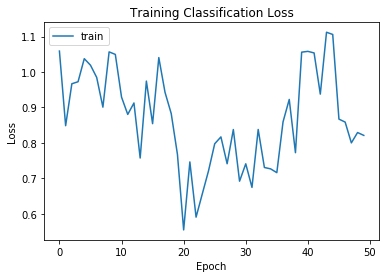

In [ ]:
# Classification Loss
plt.plot(loss_cls)
plt.title('Training Classification Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'])
plt.show()

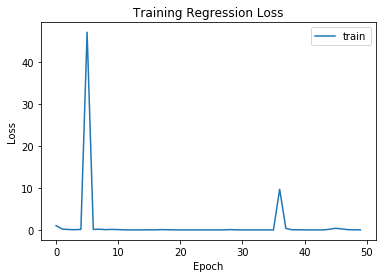

In [ ]:
# Regression Loss
plt.plot(loss_regr)
plt.title('Training Regression Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'])
plt.show()

## Accuracy Curves

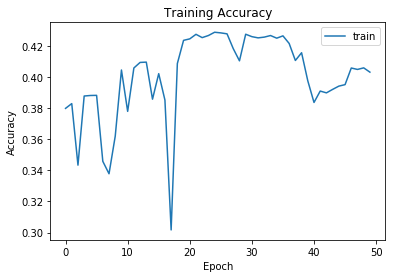

In [ ]:
# Regression Loss
plt.plot(accuracy)
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'])
plt.show()

## Testing

In [ ]:
def predict_labels(data_gen):
  X, Y, labels, index = next(data_gen)
  P_rpn = model_rpn.predict_on_batch(X)
  R_pred = rpn_to_roi(P_rpn[0], P_rpn[1],image_dim_ordering(), use_regr=True, overlap_thresh=0.4, max_boxes=300)
  R_pred = R_pred * 16
  pred_labels, acc = filter_roi(labels, R_pred, 0.6)

  return pred_labels, index

def inference(data_gen, images):
  rows = 2
  columns = 3
  fig=plt.figure(figsize=(16, 12))
  for i in range(6):
    fig.add_subplot(rows, columns, i+1, xticks=[], yticks=[])
    labels, index = predict_labels(data_gen)
    image = images[index]
    for label in labels:
      cv2.rectangle(image,(label[0], label[1]),(label[2],label[3]),(255, 0, 0))
    plt.imshow(image)
  plt.show()

In [ ]:
data_gen_train = get_anchor_gt(train_images, train_labels)
data_gen_test = get_anchor_gt(test_images, test_labels)

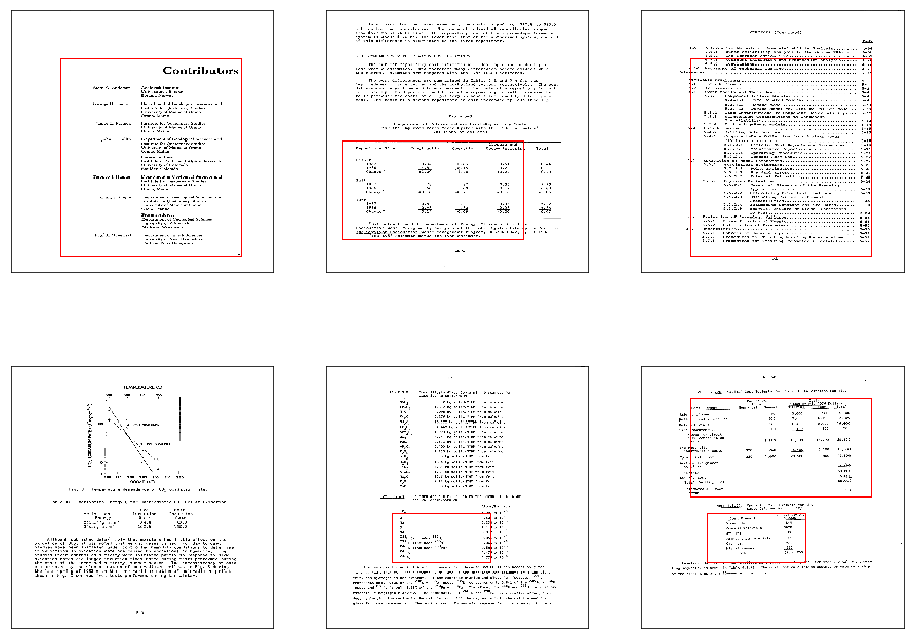

In [ ]:
inference(data_gen_train, np.copy(train_images))

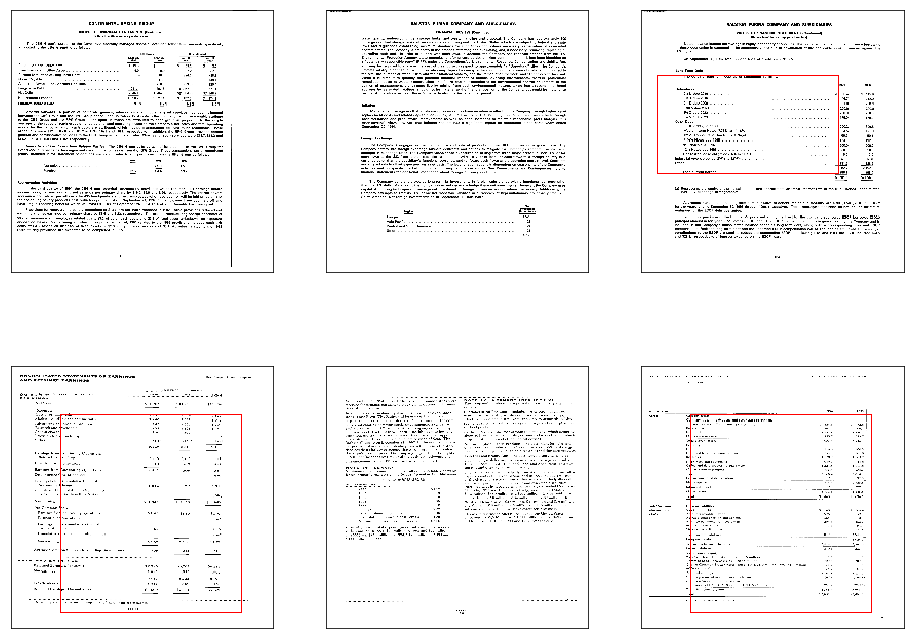

In [ ]:
inference(data_gen_test, np.copy(test_images))